# Bayesian deconvolution

Suppose that we have two separate distributions $\mathbf{x}_{0}$ and $\mathbf{x}_{f}$ and that we expect $\mathbf{x}_{0}$ to be connected to $\mathbf{x}_{HI}$ via convolution

$\begin{equation*}
\mathbf{x}_{f} = \mathbf{k} * \mathbf{x}_{0} + \mathbf{\epsilon}_{f},
\end{equation*}$

where $\mathbf{\epsilon}_{HI}$ is the error measured on $\mathbf{x}_{f}$. However, in our case, we are using a proxy data set for $\mathbf{x}_{0}$ from some other process,where errors on $\mathbf{x}_{0}$ are measured separately, and are independent of errors measured on $\mathbf{x}_{f}$. Therefore, we should actually take our model to be of the form

$\begin{align*}
\mathbf{x}_{f} &= \mathbf{k} * \mathbf{x}_{0} + (\mathbf{\epsilon}_{f} + \mathbf{k} * \mathbf{\epsilon}_{0})\\
&\equiv \mathbf{k} * \mathbf{x}_{0} + \mathbf{\epsilon}_{full},
\end{align*}$

where $\mathbf{\epsilon}_{0,f}$ are the (assumed gaussian) random errors measured on $\mathbf{x}_{0}$ and $\mathbf{x}_{f}$ respectively. Noting that the sum of gaussian random variables of mean zero is again gaussian with mean zero and variance given by the sum of the variance of the random variables, we then have the likelihood function

$\begin{equation*}
P\left(\mathbf{x}_{f} | \mathbf{x}_{0},\mathbf{k}\right) = \dfrac{1}{\sqrt{|2 \pi \mathbf{\Sigma}_{full}|}}e^{-\frac{1}{2}(\mathbf{x}_{f}-\mathbf{k} * \mathbf{x}_{0})^T \mathbf{\Sigma}_{full}^{-1} (\mathbf{x}_{f}-\mathbf{k} * \mathbf{x}_{0})},
\end{equation*}$

where the covariance matrix $\mathbf{\Sigma}_{full}$ for now will be taken as diagonal (uncorrelated errors in $\mathbf{x}_{f}$ and $\mathbf{x}_{0}$ individually) and the diagonal entries are $\mathbf{\sigma}^2_{f} + k * \mathbf{\sigma}^2_{0}$, where $\mathbf{\sigma}^2_{0,f}$ are the vectors with the variance of each datum in $\mathbf{x}_{0}$ and $\mathbf{x}_{f}$ respectively.

Now, we wish to discover the convolution kernel given data $\mathbf{x}_{f}$ and $\mathbf{x}_{0}$. Given priors $P(\mathbf{k})$, we may sample the posterior using Markov Chain Monte Carlo to get an estimate of $\mathbf{k}$ and its errors.

Below I test this model for the case of a known convolution kernel. The program will take in $\mathbf{x}_{f}$, $\mathbf{x}_{0}$, and the covariance matricies for the Gaussian distributions from which $\mathbf{\epsilon}_{0,f}$ are drawn. We will then construct $\mathbf{\Sigma}_{full}$ and extract $\mathbf{k}$ and  with marginal distribution error estimates, and compare to actual values.

Before moving on, it is interesting to note the relationship between this problem and a nearby inverse problem. In particular, we could have instead specified the convolution kernel, and the output signal $\mathbf{x}_f$ with error, and used a similar model in order to extract the initial signal $\mathbf{x}_0$. The approach is essentially the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import emcee
from deconv import distributions
#Specify the covariance matrices
cov_x = 0.005*np.array([0.005,0.001,0.05,0.1,0.2,0.25,0.1,0.07,0.02,0.003,0.05,0.0076,0.03])
cov_y = 0.0075*np.array([0.06,0.05,0.025,0.031,0.12,0.15,0.01,0.007,0.02,0.003,0.07,0.2,0.003])
#Specify expected value of x
x_avg = np.array([0.17,0.25,0.2,0.4,1.2,2.4,0.9,0.5,0.4,0.25,0.1,0.03,0.01])
#Normalize
x_avg = x_avg/np.sum(x_avg)
#Specify convolution kernel 
k = np.array([1.6,1.5,1.7,1.8,1.9,1.75,1.1,1.2,12.5,12.4,3.25,4.75,25.01])
#I decide to use the reverse here because it gave results that look more like the data we care about.
k = k[::-1]
#Calculate expected value of y (normalized)
y=convolve(x_avg,k,mode='same')
#Normalize k because this will be the inferred value of k since y will be normalized
k = k/np.sum(y)
#Normalize y after convolution with original k value
y_avg = y/np.sum(y)

In [2]:
#Here I sample from the x and y error distributions so that I can get a sense of what values of y are possible
# within our model
def lnprob(x, ivar):
    return -0.5 * np.sum(ivar * x ** 2)
ndim, nwalkers = len(y), 500
ivarx = 1. / cov_x
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
exsampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivarx])
eysampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivarx])
exsamples = exsampler.run_mcmc(p0, 1000)
eysamples = eysampler.run_mcmc(p0, 1000)

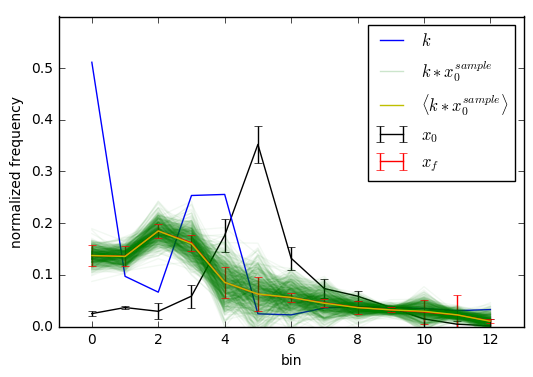

In [31]:
plt.errorbar(x=np.arange(len(x_avg)),y=x_avg,yerr=np.sqrt(cov_x),c='k',label=r'$x_{0}$')
plt.plot(k,c='b',label=r'$k$')
exsub=exsamples[0]
eysub=eysamples[0]
vectors = eysub+convolve((x_avg+exsub),k.reshape((1,int(ndim))),mode='same')
avg = np.mean(vectors,axis=0)
for i in range(len(exsub)-1):
    plt.plot(vectors[i],'g',alpha=0.05)
plt.plot(vectors[-1],'g',alpha=0.2,label=r'$k * x_{0}^{sample}$')
plt.errorbar(x=np.arange(len(y)),y=y_avg,yerr=np.sqrt(cov_y),c='r',label=r'$x_{f}$')
plt.plot(avg,c='y',label=r'$\langle k * x_{0}^{sample}\rangle$')
plt.xlim(-1,13)
plt.ylim(0,0.6)
plt.xlabel('bin')
plt.ylabel('normalized frequency')
plt.legend()
plt.savefig('samples_of_x0_vs_xf.png')
plt.show()

In [40]:
binlimits = np.array([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
alpha=0.0
ndim, nwalkers = int(len(x_avg)), 500
p0 = [np.random.uniform(low=0.0,high=0.75,size=ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, distributions.lnprob, args=(x_avg,y_avg,cov_x,cov_y,binlimits,
                                                                            alpha,ndim))
sample_run = sampler.run_mcmc(p0, 5000)

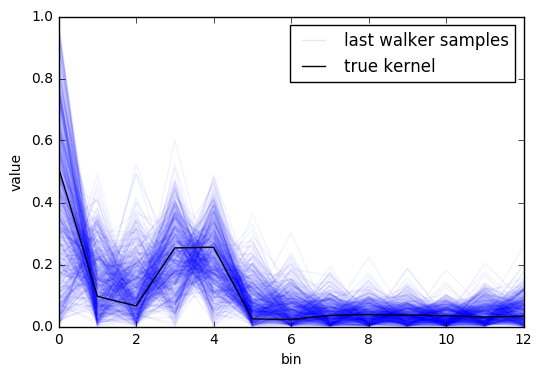

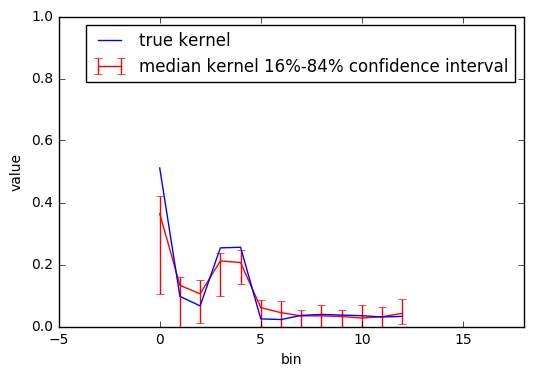

In [41]:
for i in range(nwalkers-1):
    plt.plot(sample_run[0][i,0:int(ndim)],alpha=0.05,c='b')
plt.plot(sample_run[0][-1,0:int(ndim)],alpha=0.1,c='b',label='last walker samples')
plt.plot(k,c='k',label='true kernel')
plt.xlabel('bin')
plt.ylabel('value')
plt.legend()
plt.savefig('alpha_0p0_posterior_samples_of_k.png')
plt.show()
yerr = np.array(list(zip(np.percentile(sample_run[0][:,0:int(ndim)],50 ,axis=0)-
                         np.percentile(sample_run[0][:,0:int(ndim)],16 ,axis=0),
           np.percentile(sample_run[0][:,0:int(ndim)],84 ,axis=0)-
                         np.percentile(sample_run[0][:,0:int(ndim)],50 ,axis=0)))).reshape(2,len(k))
plt.errorbar(x=np.arange(len(k)),
                         y=np.percentile(sample_run[0][:,0:int(ndim)],50 ,axis=0),
            yerr=yerr,c='r',label='median kernel 16%-84% confidence interval')
plt.xlim(-5,ndim+5)
plt.plot(k,c='b',label='true kernel')
plt.xlabel('bin')
plt.ylabel('value')
plt.legend()
plt.ylim(0,1)
plt.savefig('alpha_0p0_median_k_with_error.png')
plt.show()

In [42]:
samples = sampler.chain[:, 2500:, :].reshape((-1, ndim))

/Users/William/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/William/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


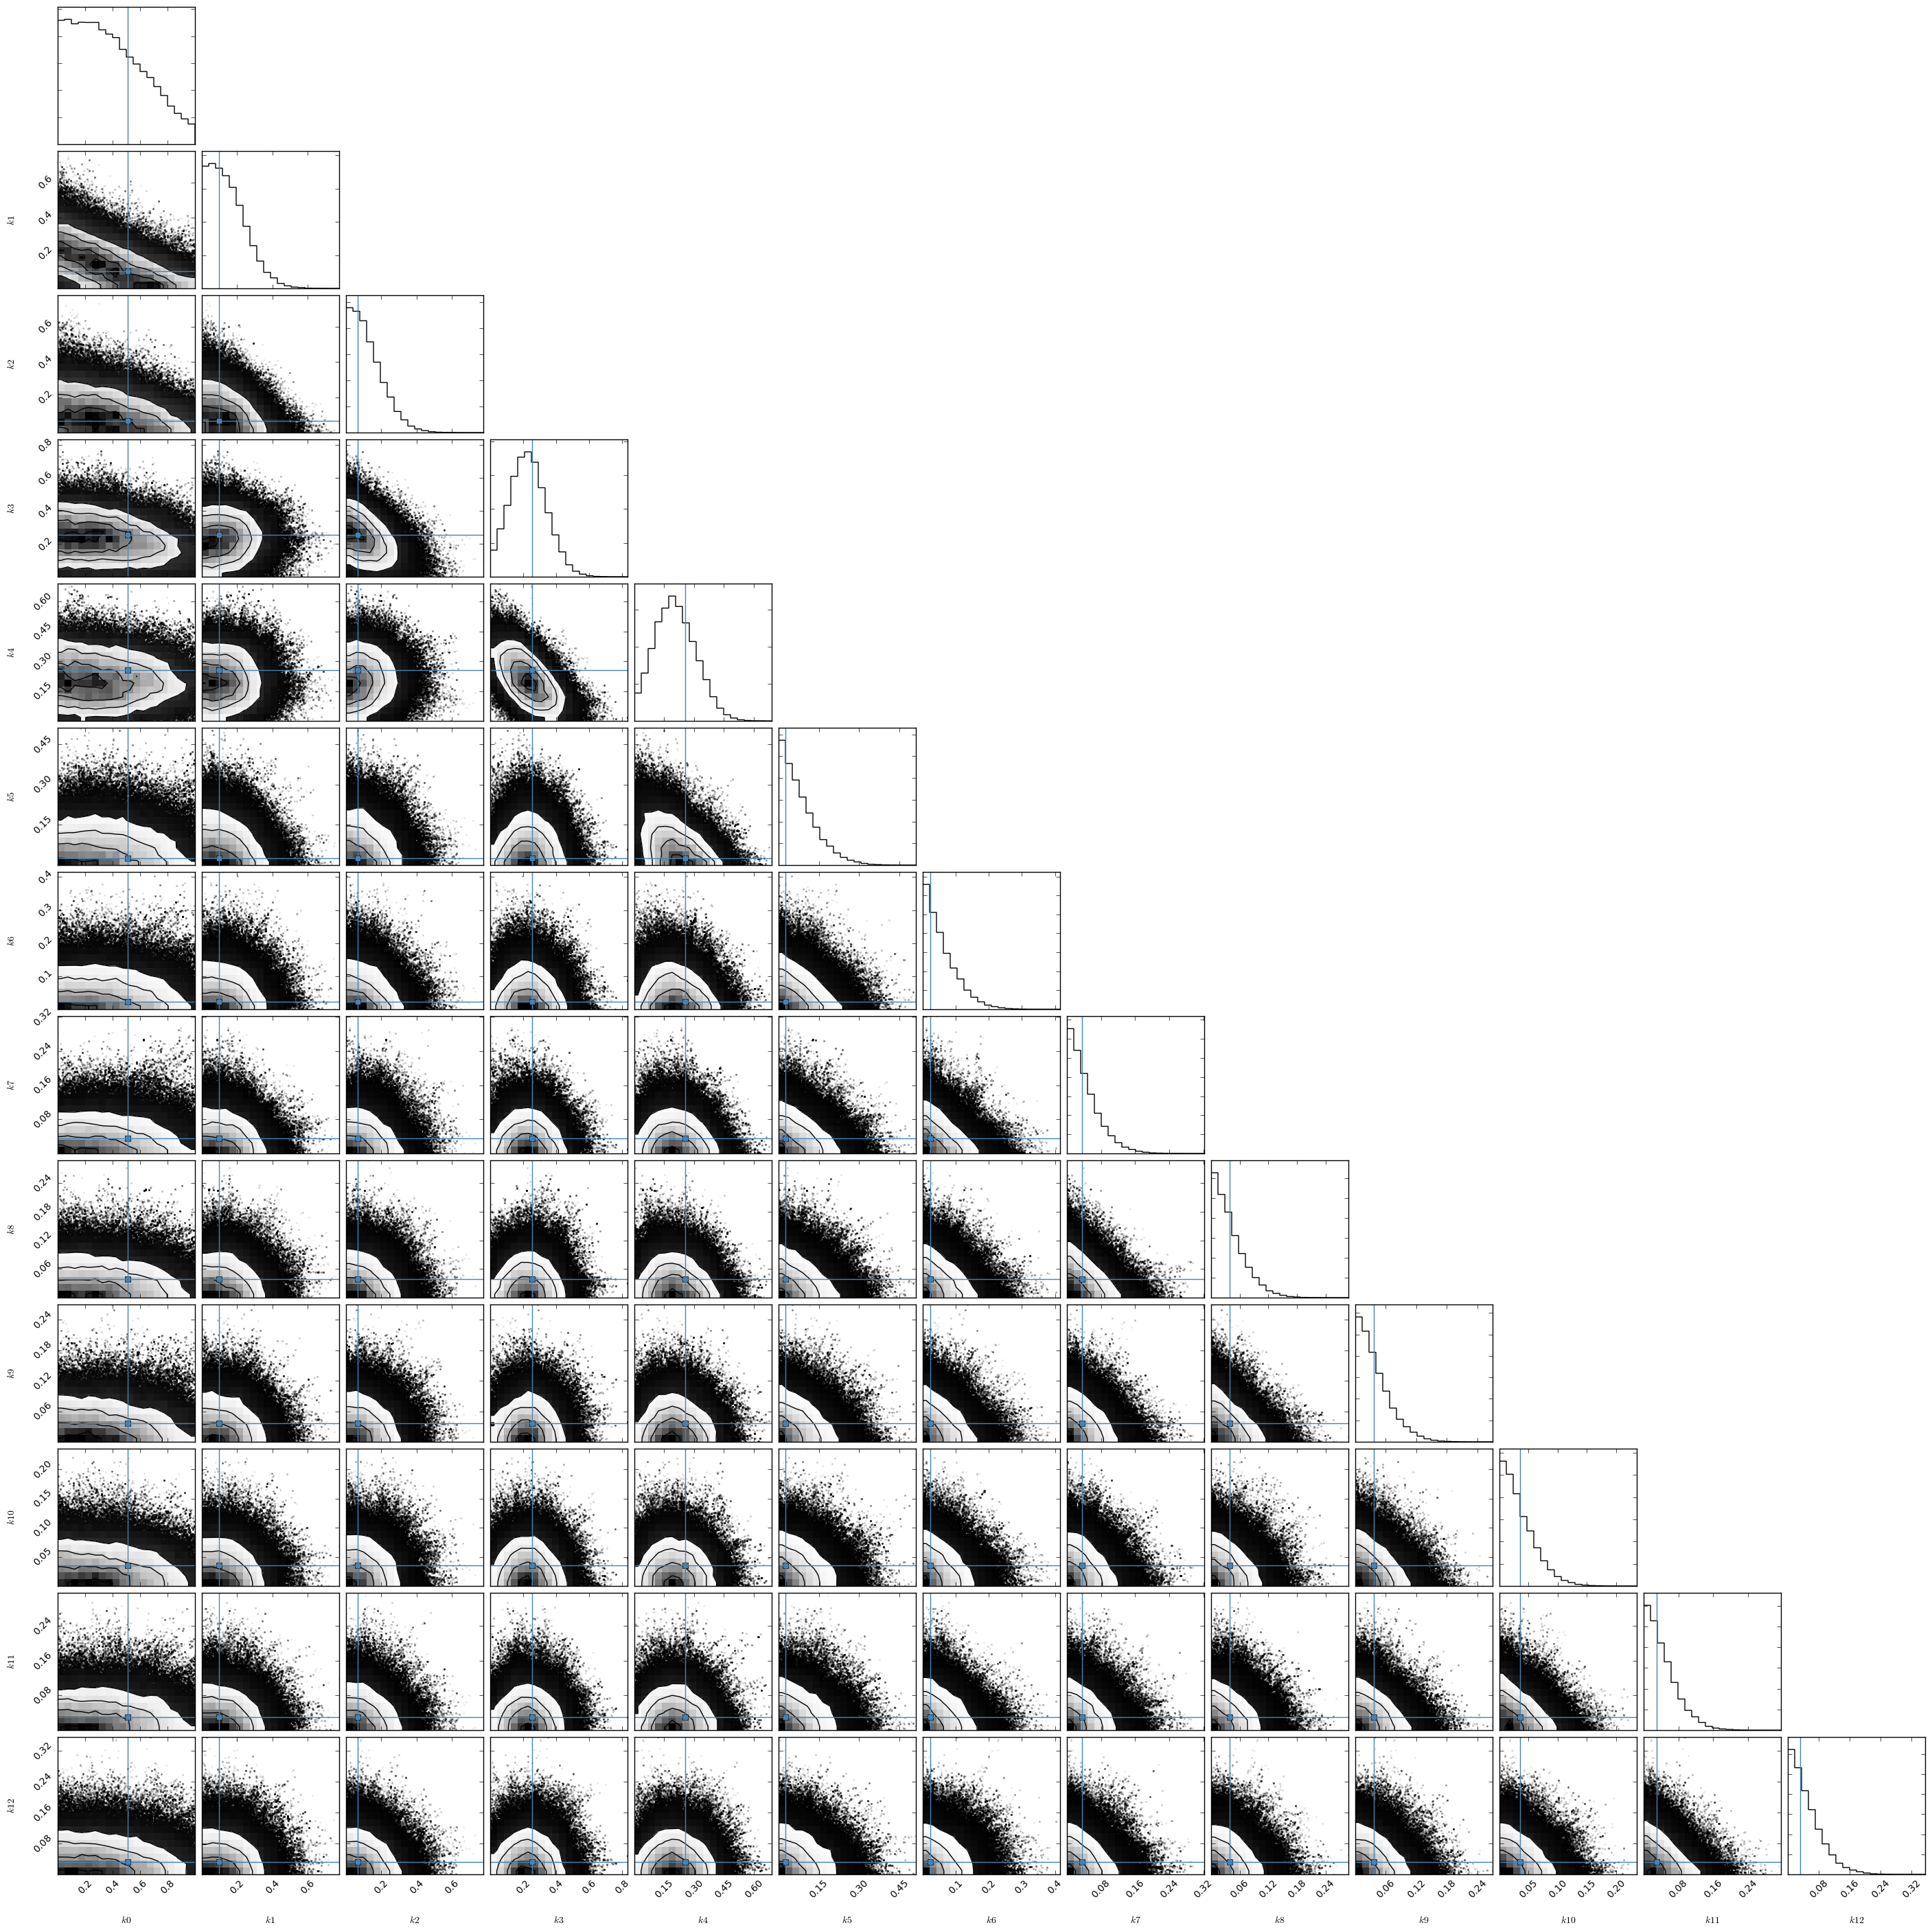

In [43]:
import corner
fig = corner.corner(samples, labels=["$k0$", "$k1$", "$k2$", "$k3$", "$k4$", "$k5$", "$k6$", "$k7$", "$k8$",
                                     "$k9$","$k10$","$k11$","$k12$"],
                      truths=[k[0], k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8],k[9],k[10],k[11],k[12]])
fig.savefig('alpha_0p0_posterior_corner_k.png')
plt.show()

In [ ]:
#export sampler object if desired 
import pickle
with open('fullerr_model_200walkers_2000steps_sampler.pkl', 'wb') as f:
    pickle.dump(sampler, f, pickle.HIGHEST_PROTOCOL)